We are using data from the The Movie Data Base on 7398 movies and a variety of metadata, including cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries. We will use this data to predict worldwide revenue for 4398 of them.

In [19]:
import pandas as pd
import numpy as np
import collections
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sb
from ast import literal_eval

%matplotlib inline

Since the data in some of the variables, e.g. genres, Keywords, cast, were originally in json format but due to the formatting of the csv file were imported as strings into the dataframe, we need to turn the strings back into lists and dictionaries.

In [82]:
 # read in data
train = pd.read_csv("train.csv", delimiter=',')
test = pd.read_csv("test.csv", delimiter=',')

na_headers = ['belongs_to_collection', 'genres', 'spoken_languages', 'production_companies', 'production_countries', 'Keywords', 'cast', 'crew']

def text_to_dict(data, cols):
    for column in cols:
        data[column] = data[column].apply(lambda x: {} if pd.isna(x) else literal_eval(x) )
    return data

train = text_to_dict(train, na_headers)
test = text_to_dict(test, na_headers)

train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [83]:
# how many columns and rows do both files have
print(train.shape)
print(test.shape)

(3000, 23)
(4398, 22)


count    3.000000e+03
mean     6.672585e+07
std      1.375323e+08
min      1.000000e+00
25%      2.379808e+06
50%      1.680707e+07
75%      6.891920e+07
max      1.519558e+09
Name: revenue, dtype: float64
0


(-10000000, 1000000000)

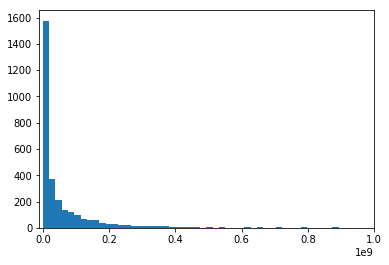

In [58]:
# get descriptive statistics for revenue variable
print(train['revenue'].describe())
print(train['revenue'].isnull().sum().sum())

plt.hist(data = train, x = 'revenue', bins = 80)
plt.xlim(-10000000,1000000000)

count    3000.000000
mean        8.463274
std        12.104000
min         0.000001
25%         4.018053
50%         7.374861
75%        10.890983
max       294.337037
Name: popularity, dtype: float64


(-1, 100)

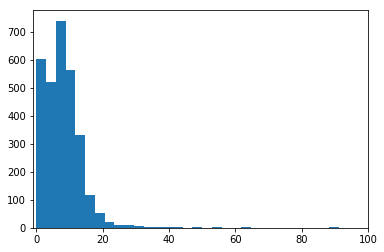

In [54]:
# analysis of the popularity variable
print(train['popularity'].describe())
plt.hist(data = train, x = 'popularity', bins = 100)
plt.xlim(-1,100)

In [89]:
# breakup the dictionary variables
def list_breakdown(data, header):
    all_list = []
    for row in data[header]:
        if row:
            for k, v in row[0].items():
                if k == 'name':
                    if v not in all_list:
                        all_list.append(v)
    return all_list
                       

In [91]:
all_crew = list_breakdown(train, 'crew')
print(sorted(all_crew))
print(len(all_crew))


['A. R. Rahman', 'A. V. M. Saravanan', 'A.R. Murugadoss', 'Aamir Khan', 'Aaron Ginsburg ', 'Aaron Katz', 'Aaron Norris', 'Aascar Ravichandran', 'Abbas Kiarostami', 'Abderrahmane Sissako', 'Abrid Shine', 'Adam Fields', 'Adam Greenberg', 'Adam Kane', 'Adam McKay', 'Adam Nielsen', 'Adam Rapp', 'Adam Resnick', 'Adam Rifkin', 'Adam Sandler', 'Adam Scott', 'Adam Sztykiel', 'Adam Wingard', 'Aditya Chopra', 'Adrian Gorton', 'Agn√®s Guillemot', 'Akira Kurosawa', 'Akiva Goldsman', 'Aksinya Gog', 'Alain Chabat', 'Alain Goldman', 'Alain Sarde', 'Alan C. Blomquist', 'Alan Caillou', 'Alan Gibson', 'Alan Heim', 'Alan Myerson', 'Alan Parker', 'Alan Shapiro', 'Alan Silvestri', 'Alastair Fothergill', 'Albert S. Ruddy', 'Alberto Iglesias', 'Alberto Rodr√≠guez', 'Alejandro Gonz√°lez I√±√°rritu', 'Aleksandr Barshak', 'Aleksandr Chubaryan', 'Aleksandr Mindadze', 'Aleksandr Proshkin', 'Aleksandr Shevtsov', 'Aleksei Sidorov', 'Aleksey Balabanov', 'Aleksey Mizgiryov', 'Aleksi M√§kel√§', 'Alessandro Genovesi', 